In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from ray.tune import Analysis
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from src.data import IFCNetPlySparse
from src.models.models import MinkowskiFCNN, MinkowskiCE2
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import sklearn.metrics as metrics
import torch.nn as nn
import MinkowskiEngine as ME
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/BIMGEOM/BIMGEOM")
test_batch_size = 70

with open("../BIMGEOM_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
train_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
val_dataset = IFCNetPlySparse(data_root, class_names, partition="train")
test_dataset = IFCNetPlySparse(data_root, class_names, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, sorted(perm[:train_len]))
val_dataset = Subset(val_dataset, sorted(perm[train_len:]))

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, collate_fn=ME.utils.SparseCollation())
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=8, collate_fn=ME.utils.SparseCollation())
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=8, collate_fn=ME.utils.SparseCollation())

In [5]:
log_dir = Path("../logs/BIMGEOM/DEFAULT_2021-09-14_00-22-50/")
analysis = Analysis(log_dir, default_metric="val_balanced_accuracy_score", default_mode="max")
best_trial_dir = Path(analysis.get_best_logdir())

with (best_trial_dir/"params.json").open("r") as f:
    config = json.load(f)

model = MinkowskiCE2(3, len(class_names), config["embedding_dim"])
model_state, _ = torch.load(best_trial_dir/"checkpoint_249"/"checkpoint")
model.load_state_dict(model_state)

<All keys matched successfully>

In [6]:
device = torch.device("cuda")
model.eval()
model.to(device)

MinkowskiCE2(
  (mlp1): Sequential(
    (0): MinkowskiLinear(in_features=3, out_features=16, bias=False)
    (1): MinkowskiBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (conv1): Sequential(
    (0): MinkowskiConvolution(in=16, out=32, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (down1): Sequential(
    (0): MinkowskiConvolution(in=48, out=32, kernel_size=[1, 1, 1], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeakyReLU()
  )
  (conv2): Sequential(
    (0): MinkowskiConvolution(in=32, out=48, kernel_size=[3, 3, 3], stride=[1, 1, 1], dilation=[1, 1, 1])
    (1): MinkowskiBatchNorm(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MinkowskiLeak

In [7]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    heatmap = sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for coords, feats, labels in tqdm(loader):
            labels = torch.tensor(labels)
                
            coords, feats, labels = coords.to(device), feats.to(device), labels.to(device)
            tensor = ME.TensorField(feats, coords)

            outputs = model(tensor)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    print(result)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

100%|██████████| 178/178 [00:12<00:00, 14.47it/s]


{'accuracy_score': 0.9374118476727785, 'balanced_accuracy_score': 0.9447912078668027, 'precision_score': 0.9428362755966493, 'recall_score': 0.9374118476727785, 'f1_score': 0.938812236267914}


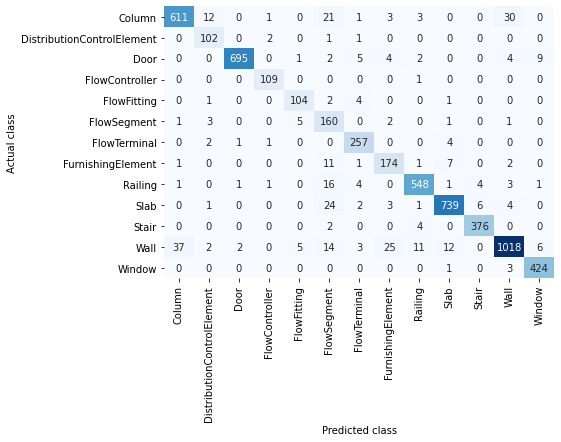

In [8]:
eval(model, train_loader, device, class_names);

100%|██████████| 76/76 [00:05<00:00, 12.73it/s]


{'accuracy_score': 0.9440559440559441, 'balanced_accuracy_score': 0.9498678425088334, 'precision_score': 0.9495028374161668, 'recall_score': 0.9440559440559441, 'f1_score': 0.9456873993631647}


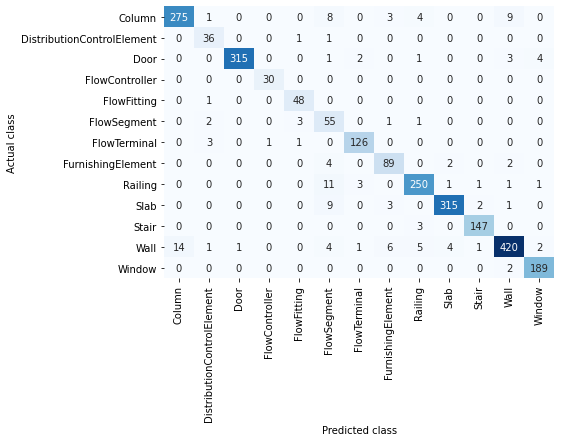

In [9]:
eval(model, val_loader, device, class_names);

100%|██████████| 64/64 [00:05<00:00, 12.40it/s]


{'accuracy_score': 0.9046683046683047, 'balanced_accuracy_score': 0.8765767160598743, 'precision_score': 0.9142834380954291, 'recall_score': 0.9046683046683047, 'f1_score': 0.9076837809262738}


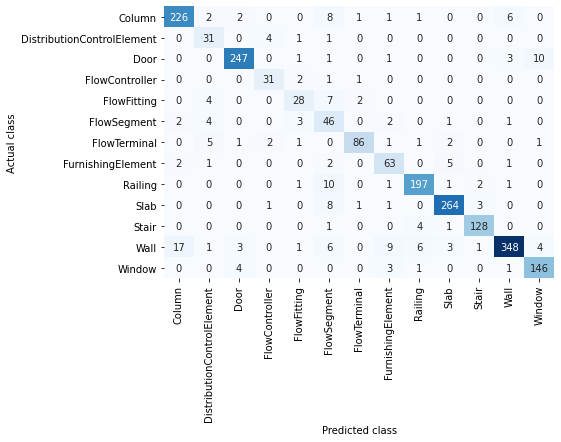

In [8]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/BIMGEOM_confusion.svg")

In [12]:
np.savez("BIMGEOMProbs.npz", labels=test_labels, probs=test_probs)

In [13]:
def plot_class_accuracies(data, class_names):
    result_table = []
    for key, value in data.items():
        model_accs = {"Model": key}
        overall_acc = 0
        labels, probs = value["labels"], value["probs"]
        predictions = np.argmax(probs, axis=1)
        correct_predictions = predictions[predictions == labels]
        for i, cn in enumerate(class_names):
            acc = len(correct_predictions[correct_predictions == i])/len(labels[labels == i])
            model_accs[cn] = np.round(acc*100, 2)
            overall_acc += acc
        overall_acc /= len(class_names)
        model_accs["Overall"] = np.round(overall_acc*100, 2)
        result_table.append(model_accs)
    df = pd.DataFrame(result_table)
    pd.set_option("display.max_columns", None)
    display(df)
    df.to_csv("ClassAccuracies.csv", index=False)

In [15]:
plot_class_accuracies({
    "BIMGEOM": {"labels": test_labels, "probs": test_probs}
}, class_names)

,Model,IfcColumn,IfcDistributionControlElement,IfcDoor,IfcFlowController,IfcFlowFitting,IfcFlowSegment,IfcFlowTerminal,IfcFurnishingElement,IfcRailing,IfcSlab,IfcStair,IfcWall,IfcWindow,Overall
0,BIMGEOM,91.5,83.78,93.92,88.57,68.29,77.97,86.0,85.14,92.49,94.96,95.52,87.22,94.19,87.66


In [10]:
coords, feats, labels = next(iter(train_loader))
coords, feats = coords.to(device), feats.to(device)
dummy_input = ME.TensorField(feats, coords)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)

9.320550610224405


In [8]:
coords, feats, labels = next(iter(test_loader))
coords, feats = coords.to(device), feats.to(device)
dummy_input = ME.TensorField(feats, coords)

repetitions=100
total_time = 0
with torch.no_grad():
    for rep in range(repetitions):
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model(dummy_input)
        ender.record()
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
        curr_time = starter.elapsed_time(ender)/1000
        total_time += curr_time
Throughput =   (repetitions*test_batch_size)/total_time
print('Final Throughput:',Throughput)

Final Throughput: 1526.44731848534


In [12]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [13]:
wrong_pred_dir = Path("../data/external/IFCGeomUniform/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.files[i].stem}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.files[i]
    shutil.copy(str(raw_data_dict[filename.stem]), str(target_dir / f"{filename.stem}_{prediction_str}.obj"))

0040c7bf0e474141bb19bdf8ed59e080, Label: IfcAirTerminal, Prediction: IfcValve


KeyError: '0040c7bf0e474141bb19bdf8ed59e080'